In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import numpy as np
from tools.model import Unet

In [2]:
model = Unet().to('cuda')

In [3]:
checkpoint = torch.load('/userhome/jeon_mg/workspace/project/NF2_notebooks/cnn/model_piunet_opt_b3_elr/model_5001.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval();

In [4]:
inputs = np.load('data/inputs_11158.npy')
outputs = np.load('data/outputs_11158.npy')

In [5]:
inputs = torch.Tensor(inputs).to('cuda')
labels = outputs

inputs.shape, labels.shape

(torch.Size([66, 3, 513, 257, 1]), (66, 3, 513, 257, 50))

In [6]:
model_input = torch.permute(inputs, (0, 4, 3, 2, 1))
model_input.shape

torch.Size([66, 1, 257, 513, 3])

In [7]:
b_norm = 2500

In [8]:
N = model_input.shape[0]
N

66

In [9]:
bs = []
for i in range(N):
    model_input[i].shape
    b = model(model_input[i][None, ...])
    b = b.cpu().detach().numpy().transpose(0, 3, 2, 1, 4)*b_norm
    bs.append(b)
bs = np.array(bs)
bs.shape

(66, 1, 513, 257, 50, 3)

In [10]:
bs = bs[:, 0, ...]
bs.shape

(66, 513, 257, 50, 3)

In [11]:
b2 = (bs**2).sum(-1).sum((1, 2, 3))
b2.shape

(66,)

In [12]:
b2[0]

69764465000.0

In [13]:
labels.shape

(66, 3, 513, 257, 50)

In [14]:
B2 = ((labels*b_norm)**2).sum(1).sum((1, 2, 3))
B2.shape

(66,)

In [15]:
B2[0]

80785965000.0

In [16]:
eps = b2/B2 
eps[0]

0.8635716

In [17]:
outputs_pot = np.load('data/outputs_pot_11158.npy')

In [18]:
outputs_pot.shape

(66, 3, 513, 257, 50)

In [19]:
Bpot2 = ((outputs_pot*b_norm)**2).sum(1).sum((1, 2, 3))
Bpot2.shape

(66,)

In [20]:
Bpot2[0]

66449002000.0

In [21]:
import matplotlib.pyplot as plt

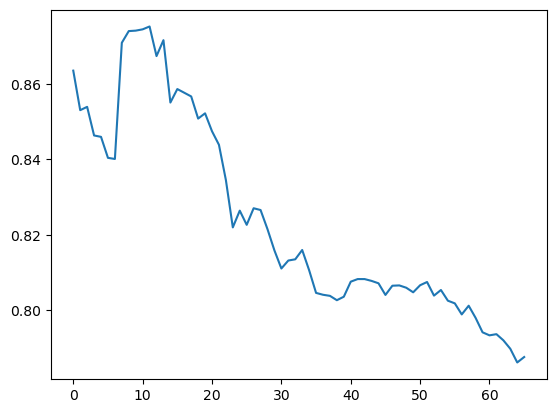

In [22]:
plt.plot(eps)

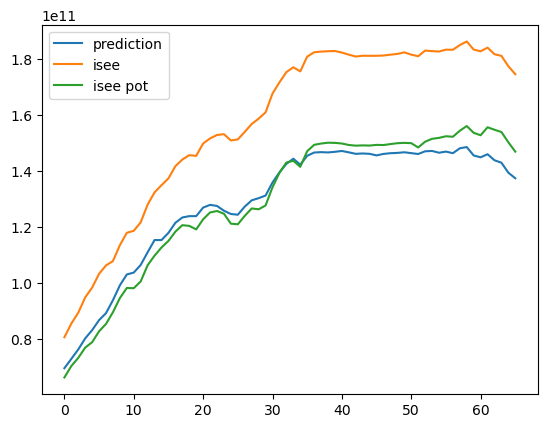

In [23]:
plt.plot(b2, label='prediction')
plt.plot(B2, label='isee')
plt.plot(Bpot2, label='isee pot')
plt.legend()

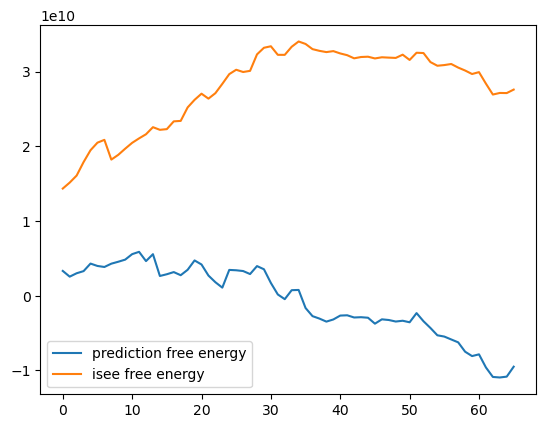

In [29]:
plt.plot(b2-Bpot2, label='prediction free energy')
plt.plot(B2-Bpot2, label='isee free energy')
plt.legend()

In [24]:
b = bs[0]
B = labels[0].transpose(1, 2, 3, 0)*b_norm
b.shape, B.shape

((513, 257, 50, 3), (513, 257, 50, 3))

In [25]:
from tools.ploting import plot_overview
from tools.metric import evaluate
from tools.metric_another import metrics

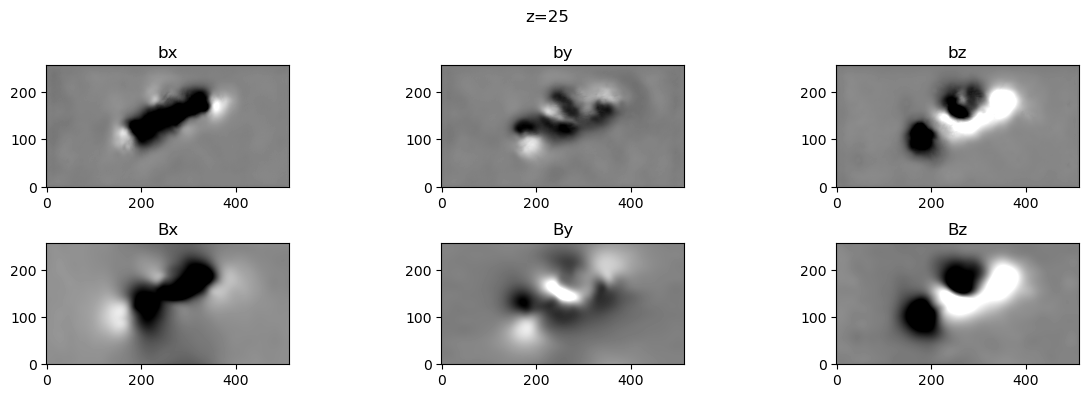

In [26]:
plot_overview(b, B, z=25, b_norm=100)

In [27]:
evaluate(b, B)

/userhome/jeon_mg/workspace/project/NF2_compare/tools/metric.py:58: RuntimeWarning: invalid value encountered in divide
  result['C_cs'] = 1 / M * np.sum((B * b).sum(-1) / vector_norm(B) / vector_norm(b))
/userhome/jeon_mg/workspace/project/NF2_compare/tools/metric.py:63: RuntimeWarning: divide by zero encountered in divide
  E_m = 1 / M * (vector_norm(b - B) / vector_norm(B)).sum()
/userhome/jeon_mg/workspace/project/NF2_compare/tools/metric.py:76: RuntimeWarning: invalid value encountered in divide
  result['sig_J_1e2_B'] = (vector_norm(np.cross(J, B, -1)) / vector_norm(B)).sum() / (vector_norm(J).sum() + 1e-6) * 1e2
/userhome/jeon_mg/workspace/project/NF2_compare/tools/metric.py:81: RuntimeWarning: invalid value encountered in divide
  result['L1_B'] = (vector_norm(np.cross(curl(B), B, -1)) ** 2 / vector_norm(B) ** 2).mean()


{'C_vec': 0.9402851,
 'C_cs': nan,
 "E_n'": 0.4791209101676941,
 "E_m'": -inf,
 'eps': 0.8635716,
 'sig_J_1e2': 80.97701538457186,
 'sig_J_1e2_B': nan,
 'L1': 127.22728,
 'L2': 78.07716,
 'L1_B': nan,
 'L2_B': 54.976227,
 'L2n': 14.679230749607086,
 'L2n_B': 458290650.0}

In [28]:
metrics(b, B)

{'c_vec': 0.9402851,
 'c_cs': 0.4747904293808451,
 'c_cs_ep': 0.45643551702429436,
 "E_n'": 0.4791209101676941,
 "E_m'": 0.11808299390933019,
 "E_m'_ep": -183549.36917741824,
 'eps': 0.8635716}